In [5]:
from json_file_func import *
from TPF import *
import pandas as pd
import numpy as np
from df_functions import *

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [28]:
X_file_path = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H1\labels_count\labels_count_table-H1-60-30.csv"
y_file_path = r"C:\final_project\H1_2.csv"
output_folder = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H1\labels_count"
train_or_test = 'H1_60-30'
hs_md_hsmd = ''
label = 'HDRS21_Improvement'

In [29]:
merge_x_and_y(X_file_path, y_file_path, output_folder, train_or_test, hs_md_hsmd,label)

In [30]:
df=pd.read_csv(r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H1\labels_count\X_H1_60-30__on_HDRS21_Improvement.csv")

In [41]:
df['subject'] = df["Id"].str[0:5]
median_value = df['HDRS21_Improvement'].median()

# Step 2: Create a new label column
df['above_median_HDRS21_Improvement'] =  df['HDRS21_Improvement'].apply(lambda x: 1.0 if x > median_value else 0.0)

<Axes: >

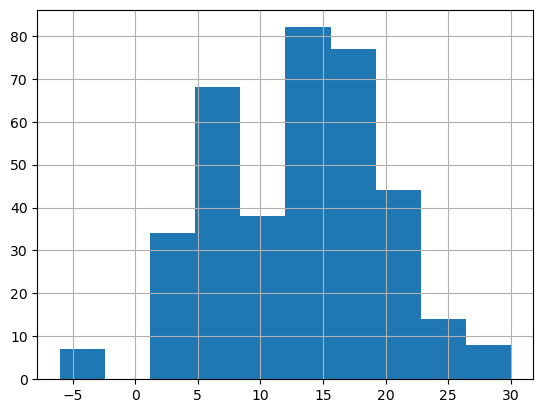

In [38]:
df['HDRS21_Improvement'].hist()

In [39]:
median_value

13.0

In [32]:
subject = 'subject'
label = 'above_median_HDRS21_Improvement'

best_train_df, best_test_df, original_df_label_ratio, best_split_label_ratio = train_test_split_by_subject(df,label,subject,test_size=0.2, random_state=42)

In [33]:
original_df_label_ratio

0.0    0.510753
1.0    0.489247
Name: above_median_HDRS21_Improvement, dtype: float64

In [34]:
best_split_label_ratio

0.0    0.512821
1.0    0.487179
Name: above_median_HDRS21_Improvement, dtype: float64

In [40]:
def filter_by_percentile(df, column):
    column_data = df[column]
    threshold_high = column_data.quantile(0.70)
    threshold_low = column_data.quantile(0.30)
    filtered_df = df[(column_data > threshold_high) | (column_data < threshold_low)]
    return filtered_df

In [42]:
from sklearn.model_selection import GridSearchCV

models = ['XGBoost', 'RandomForest','Catboost','TPF','TPF_top3','TPF_top5','TPF_top7','TPF_top9','TPF_top11','TPF_top13','TPF_top15']
metrics = ['Accuracy', 'Sensitivity', 'Specificity']
subject = 'subject'
label = 'above_median_HDRS21_Improvement'
combined_results = pd.DataFrame()

for model_name in models:
    accuracy_scores = []
    sensitivity_scores = []
    specificity_scores = []
    
    for i in range(1, 10):
        best_train_df, best_test_df, original_df_label_ratio, best_split_label_ratio = train_test_split_by_subject(df,label,subject,test_size=0.2, random_state=i)
        best_train_df = filter_by_percentile(best_train_df,'HDRS21_Improvement')
        X_train = best_train_df.drop(columns=['Id','subject','above_median_HDRS21_Improvement','HDRS21_Improvement'])
        X_test = best_test_df.drop(columns=['Id','subject','above_median_HDRS21_Improvement','HDRS21_Improvement'])
        y_train = best_train_df["above_median_HDRS21_Improvement"]
        y_test = best_test_df["above_median_HDRS21_Improvement"]

        scaler = StandardScaler()
        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        if model_name == 'XGBoost':
            param_grid = {
                'n_estimators': [50],
                'max_depth': [6],
                'learning_rate': [ 0.1] 
                
            }
            model = XGBClassifier()
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
            grid_search.fit(scaled_X_train, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(scaled_X_test)
        elif model_name == 'RandomForest':
            param_grid = {
                'n_estimators': [50],
                'max_depth': [ 5],
                'max_features': ['sqrt']
            }
            model = RandomForestClassifier()
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
            grid_search.fit(scaled_X_train, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(scaled_X_test)
        elif model_name == 'Catboost':
            model = CatBoostClassifier(
                iterations=100,
                learning_rate=0.1,
                depth=6,
                l2_leaf_reg=1,
                random_strength=0.5,
                border_count=32,
                random_state=42
            )
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
        elif model_name == 'TPF':
            y_pred = TPF_classifier(pd.DataFrame(scaled_X_train),y_train,pd.DataFrame(scaled_X_test),y_test)
        elif model_name == 'TPF_top3':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=3)
        elif model_name == 'TPF_top5':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=5)
        elif model_name == 'TPF_top7':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=7)
        elif model_name == 'TPF_top9':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=9)
        elif model_name == 'TPF_top11':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=11)
        elif model_name == 'TPF_top13':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=13)
        elif model_name == 'TPF_top15':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=15)
            
        pred_acc = accuracy_score(y_test, y_pred)
        pred_sensitivity = recall_score(y_test, y_pred)
        pred_specificity = recall_score(y_test, y_pred, pos_label = 0)
        

        accuracy_scores.append(pred_acc)
        sensitivity_scores.append(pred_sensitivity)
        specificity_scores.append(pred_specificity)

    mean_acc = np.mean(accuracy_scores)
    mean_sensitivity = np.mean(sensitivity_scores)
    mean_specificity = np.mean(specificity_scores)
    
    std_acc = np.std(accuracy_scores)
    std_sensitivity = np.std(sensitivity_scores)
    std_specificity = np.std(specificity_scores)
    
    
    model_results = {
        'Model': model_name,
        'Accuracy': f"{mean_acc:.2f} ± {std_acc:.2f}",
        'Sensitivity': f"{mean_sensitivity:.2f} ± {std_sensitivity:.2f}",
        'Specificity': f"{mean_specificity:.2f} ± {std_specificity:.2f}",
        
    }
    
    model_row = pd.DataFrame(model_results, index=[0])
    combined_results = pd.concat([combined_results, model_row])

# Reset index of combined_results DataFrame
combined_results.reset_index(drop=True, inplace=True)



0:	learn: 0.5565031	total: 15.3ms	remaining: 1.51s
1:	learn: 0.4718586	total: 28.2ms	remaining: 1.38s
2:	learn: 0.3815541	total: 38.7ms	remaining: 1.25s
3:	learn: 0.3093720	total: 50.2ms	remaining: 1.2s
4:	learn: 0.2601381	total: 61.6ms	remaining: 1.17s
5:	learn: 0.2099137	total: 71.4ms	remaining: 1.12s
6:	learn: 0.1679356	total: 84ms	remaining: 1.11s
7:	learn: 0.1403958	total: 102ms	remaining: 1.17s
8:	learn: 0.1168020	total: 113ms	remaining: 1.14s
9:	learn: 0.1010414	total: 123ms	remaining: 1.11s
10:	learn: 0.0872521	total: 135ms	remaining: 1.09s
11:	learn: 0.0769456	total: 146ms	remaining: 1.07s
12:	learn: 0.0659334	total: 161ms	remaining: 1.07s
13:	learn: 0.0566650	total: 172ms	remaining: 1.05s
14:	learn: 0.0490813	total: 182ms	remaining: 1.03s
15:	learn: 0.0442138	total: 192ms	remaining: 1.01s
16:	learn: 0.0387749	total: 203ms	remaining: 991ms
17:	learn: 0.0343277	total: 213ms	remaining: 970ms
18:	learn: 0.0310544	total: 225ms	remaining: 960ms
19:	learn: 0.0288908	total: 237ms	rem

67:	learn: 0.0026132	total: 637ms	remaining: 300ms
68:	learn: 0.0025599	total: 646ms	remaining: 290ms
69:	learn: 0.0025138	total: 656ms	remaining: 281ms
70:	learn: 0.0024280	total: 668ms	remaining: 273ms
71:	learn: 0.0023626	total: 677ms	remaining: 263ms
72:	learn: 0.0022814	total: 685ms	remaining: 254ms
73:	learn: 0.0022452	total: 695ms	remaining: 244ms
74:	learn: 0.0022102	total: 703ms	remaining: 234ms
75:	learn: 0.0021745	total: 712ms	remaining: 225ms
76:	learn: 0.0021343	total: 720ms	remaining: 215ms
77:	learn: 0.0020961	total: 728ms	remaining: 205ms
78:	learn: 0.0020628	total: 735ms	remaining: 195ms
79:	learn: 0.0020287	total: 743ms	remaining: 186ms
80:	learn: 0.0019905	total: 751ms	remaining: 176ms
81:	learn: 0.0019416	total: 759ms	remaining: 167ms
82:	learn: 0.0018929	total: 766ms	remaining: 157ms
83:	learn: 0.0018605	total: 774ms	remaining: 147ms
84:	learn: 0.0018305	total: 781ms	remaining: 138ms
85:	learn: 0.0017967	total: 789ms	remaining: 129ms
86:	learn: 0.0017688	total: 798

38:	learn: 0.0083662	total: 477ms	remaining: 747ms
39:	learn: 0.0080322	total: 489ms	remaining: 733ms
40:	learn: 0.0076275	total: 501ms	remaining: 721ms
41:	learn: 0.0073077	total: 518ms	remaining: 715ms
42:	learn: 0.0069195	total: 528ms	remaining: 700ms
43:	learn: 0.0066863	total: 539ms	remaining: 686ms
44:	learn: 0.0064012	total: 550ms	remaining: 672ms
45:	learn: 0.0060984	total: 561ms	remaining: 658ms
46:	learn: 0.0058275	total: 573ms	remaining: 646ms
47:	learn: 0.0056164	total: 584ms	remaining: 633ms
48:	learn: 0.0053806	total: 598ms	remaining: 622ms
49:	learn: 0.0051868	total: 611ms	remaining: 611ms
50:	learn: 0.0050145	total: 625ms	remaining: 600ms
51:	learn: 0.0048186	total: 638ms	remaining: 589ms
52:	learn: 0.0046685	total: 649ms	remaining: 575ms
53:	learn: 0.0045277	total: 660ms	remaining: 563ms
54:	learn: 0.0043476	total: 672ms	remaining: 550ms
55:	learn: 0.0042332	total: 682ms	remaining: 536ms
56:	learn: 0.0040850	total: 696ms	remaining: 525ms
57:	learn: 0.0039534	total: 711

10:	learn: 0.0786341	total: 111ms	remaining: 894ms
11:	learn: 0.0667782	total: 122ms	remaining: 898ms
12:	learn: 0.0581950	total: 133ms	remaining: 887ms
13:	learn: 0.0517029	total: 143ms	remaining: 876ms
14:	learn: 0.0447171	total: 152ms	remaining: 864ms
15:	learn: 0.0396929	total: 162ms	remaining: 852ms
16:	learn: 0.0359469	total: 174ms	remaining: 847ms
17:	learn: 0.0321537	total: 185ms	remaining: 841ms
18:	learn: 0.0290974	total: 195ms	remaining: 830ms
19:	learn: 0.0262871	total: 206ms	remaining: 825ms
20:	learn: 0.0238766	total: 218ms	remaining: 819ms
21:	learn: 0.0214627	total: 227ms	remaining: 806ms
22:	learn: 0.0197565	total: 237ms	remaining: 793ms
23:	learn: 0.0182699	total: 246ms	remaining: 780ms
24:	learn: 0.0165528	total: 256ms	remaining: 768ms
25:	learn: 0.0151519	total: 265ms	remaining: 756ms
26:	learn: 0.0142149	total: 275ms	remaining: 743ms
27:	learn: 0.0132105	total: 286ms	remaining: 734ms
28:	learn: 0.0123564	total: 295ms	remaining: 722ms
29:	learn: 0.0114645	total: 305

82:	learn: 0.0020192	total: 945ms	remaining: 194ms
83:	learn: 0.0019800	total: 957ms	remaining: 182ms
84:	learn: 0.0019496	total: 969ms	remaining: 171ms
85:	learn: 0.0019077	total: 979ms	remaining: 159ms
86:	learn: 0.0018569	total: 989ms	remaining: 148ms
87:	learn: 0.0018247	total: 999ms	remaining: 136ms
88:	learn: 0.0017961	total: 1.01s	remaining: 125ms
89:	learn: 0.0017683	total: 1.02s	remaining: 113ms
90:	learn: 0.0017458	total: 1.03s	remaining: 102ms
91:	learn: 0.0017172	total: 1.04s	remaining: 90.4ms
92:	learn: 0.0016849	total: 1.05s	remaining: 79ms
93:	learn: 0.0016587	total: 1.06s	remaining: 67.6ms
94:	learn: 0.0016323	total: 1.07s	remaining: 56.3ms
95:	learn: 0.0016129	total: 1.08s	remaining: 45ms
96:	learn: 0.0015828	total: 1.09s	remaining: 33.7ms
97:	learn: 0.0015503	total: 1.1s	remaining: 22.5ms
98:	learn: 0.0015206	total: 1.11s	remaining: 11.3ms
99:	learn: 0.0014929	total: 1.13s	remaining: 0us
0:	learn: 0.5493890	total: 11.8ms	remaining: 1.17s
1:	learn: 0.4261106	total: 21.

53:	learn: 0.0042883	total: 510ms	remaining: 435ms
54:	learn: 0.0041479	total: 520ms	remaining: 425ms
55:	learn: 0.0040423	total: 528ms	remaining: 415ms
56:	learn: 0.0039543	total: 536ms	remaining: 405ms
57:	learn: 0.0038230	total: 544ms	remaining: 394ms
58:	learn: 0.0037332	total: 552ms	remaining: 384ms
59:	learn: 0.0036357	total: 560ms	remaining: 373ms
60:	learn: 0.0035341	total: 569ms	remaining: 364ms
61:	learn: 0.0034061	total: 577ms	remaining: 354ms
62:	learn: 0.0032890	total: 585ms	remaining: 344ms
63:	learn: 0.0031756	total: 593ms	remaining: 334ms
64:	learn: 0.0030775	total: 601ms	remaining: 324ms
65:	learn: 0.0030152	total: 610ms	remaining: 314ms
66:	learn: 0.0029400	total: 618ms	remaining: 304ms
67:	learn: 0.0028843	total: 625ms	remaining: 294ms
68:	learn: 0.0028097	total: 633ms	remaining: 284ms
69:	learn: 0.0027527	total: 641ms	remaining: 275ms
70:	learn: 0.0026939	total: 649ms	remaining: 265ms
71:	learn: 0.0026292	total: 657ms	remaining: 256ms
72:	learn: 0.0025906	total: 666

In [43]:
combined_results

,Model,Accuracy,Sensitivity,Specificity
0,XGBoost,0.56 ± 0.09,0.40 ± 0.17,0.71 ± 0.19
1,RandomForest,0.60 ± 0.07,0.36 ± 0.16,0.83 ± 0.13
2,Catboost,0.58 ± 0.08,0.37 ± 0.17,0.79 ± 0.15
3,TPF,0.52 ± 0.14,0.40 ± 0.16,0.64 ± 0.19
4,TPF_top3,0.59 ± 0.13,0.41 ± 0.23,0.77 ± 0.13
5,TPF_top5,0.59 ± 0.13,0.39 ± 0.22,0.78 ± 0.12
6,TPF_top7,0.60 ± 0.14,0.38 ± 0.22,0.80 ± 0.11
7,TPF_top9,0.61 ± 0.13,0.38 ± 0.20,0.84 ± 0.13
8,TPF_top11,0.62 ± 0.13,0.37 ± 0.17,0.86 ± 0.14
9,TPF_top13,0.62 ± 0.11,0.36 ± 0.16,0.87 ± 0.14


In [37]:
combined_results.to_csv(r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H1\result_tables\H1_6030_above_median_HDRS21_imrovement_filtered_percent_ASS.csv")